In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

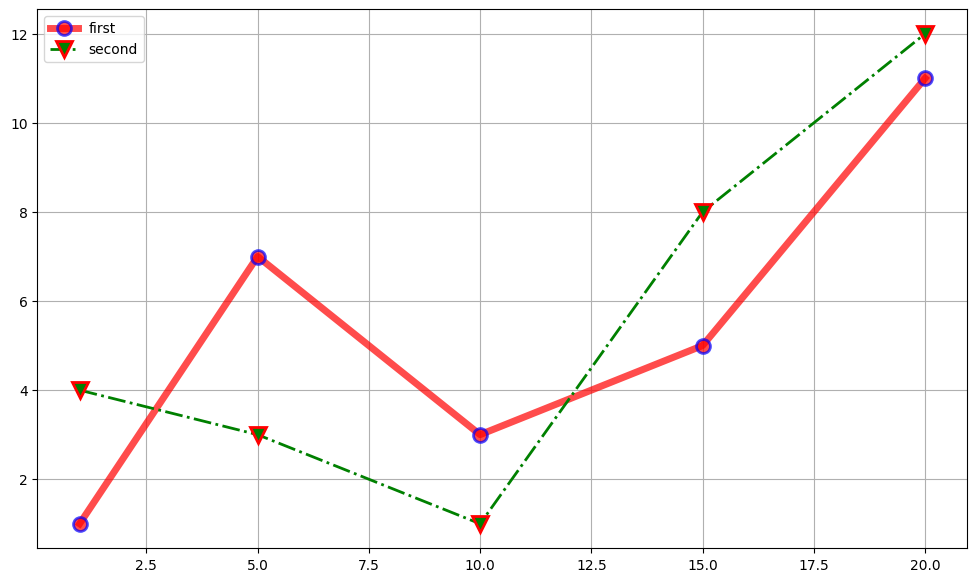

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import sqlite3
import os
import json
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def visualise_pics(dataset, indexes):
    items = [dataset[index] for index in indexes]
    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, (image, _) in enumerate(items):
        ax.ravel()[i].imshow(image.numpy().transpose([1, 2, 0]))
        ax.ravel()[i].set_axis_off()
    plt.show()

def visualise_1pic(img: torch.Tensor) -> None:
    plt.imshow(torch.einsum("chw->hwc", img))
    plt.plot()

In [6]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = ["_".join(path.parts[-3:-2][0].split("_")[:level]) for path in img_paths]
    if level != 1:
        model_name = "_".join(target[0].split("_")[:level-1])
    else:
        model_name = "full_model"
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

        # пока убрали сохранение
#         label_encoder_pickle_file.unlink(missing_ok=True)

#         with open(label_encoder_pickle_file, 'wb') as handle:
#             pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))
    
    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target, model_name


def get_traintestsplit(img_paths : list[Path],
                       target_enc : list,
                       SEED : int,
                       ):
    
    train_paths, test_paths, ytrain, ytest = train_test_split(img_paths, target_enc,
                                                              test_size=0.2,
                                                              stratify=target_enc,
                                                              random_state=SEED)
    return train_paths, test_paths, ytrain, ytest

In [7]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths,
                 target=None,
                 transform=None):

        self.img_paths = img_paths
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        #img =  read_image(str(img_path))
        img = Image.open(str(img_path)).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target is not None:
            label = self.target[index]
            return img, label

        return img


    def __len__(self):
        return len(self.img_paths)

In [8]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data/data"
processor = MobileNet_V2_Weights.IMAGENET1K_V2.transforms(
    antialias=True,
)

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, _, idx2target, model_name = get_target(data_dir,
                                                              feedbacks=False,
                                                              level=2,
                                                              category1="Канцтовары",
                                                              category2="Бумажная&продукция")
train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

train_dataset = WbDataset(train_paths, ytrain, processor)
test_dataset = WbDataset(test_paths, ytest, processor)

In [9]:
image = train_dataset[0]

# чекаем что размеры консистентны
image[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


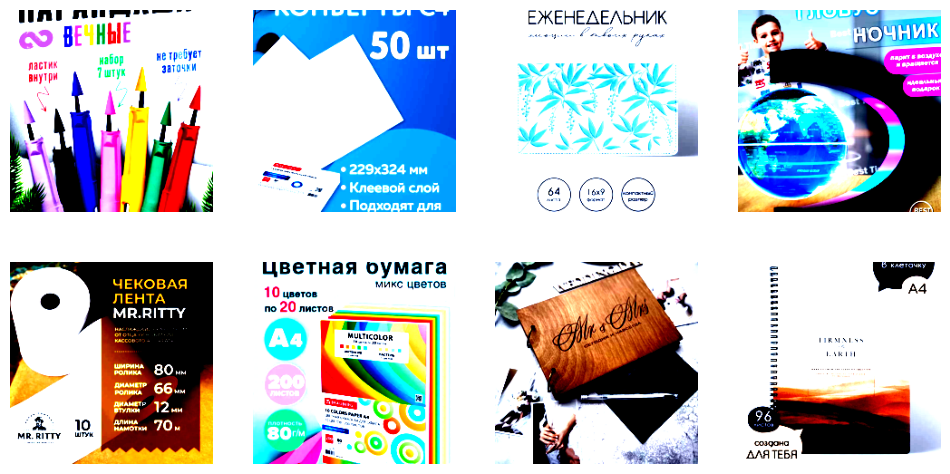

In [10]:
length = len(train_dataset)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise_pics(train_dataset, indexes)

In [11]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        data, targets = zip(*batch)
        data = torch.stack(data)
        targets = torch.tensor(targets)

        if self.mixes is not None:
            data, target = self.mixes(data, targets)
        if self.transform is not None:
            data = self.transform(data)
        return data, targets

In [12]:
#dataset = torch.utils.data.Subset(dataset, [i for i in range(100)])
BATCH_SIZE = 32

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [13]:
# elem = next(iter(train_loader))
# elem[0].shape

# visualise_1pic(elem[0][0])

In [14]:
models_tree = Path.cwd() / "models_tree"
if not models_tree.exists():
    models_tree.mkdir()
else:
    print("Каталог уже существует")

Каталог уже существует


In [15]:
pretrain_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)

In [16]:
#pretrain_model 

In [17]:
class Model(torch.nn.Module):
    def __init__(
        self,
        module_features,
        num_classes: int,
        module_out_size: int = 1280,
        dropout_prob: float = 0.3,
    ):
        super().__init__()
        self.module_features = module_features
        self.module_avgpool = torch.nn.AdaptiveAvgPool2d(output_size=1)
        self.out = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=module_out_size, out_features=num_classes),
        )

    def forward(self, inputs):
        step_1 = self.module_features(inputs)
        step_2 = self.module_avgpool(step_1)
        logits = self.out(torch.flatten(step_2, 1))

        return logits

In [18]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(3, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1), (2, 0), (2, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

In [19]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        train_transform,
        train_mixes,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for data, target in tqdm(train_loader, desc=tqdm_desc):
#             data = data.to(self.device)
#             target = target.to(self.device)
            target_mult = target
            if train_mixes is not None:
                data, target_mult = train_mixes(data, target)
            if train_transform is not None:
                data = train_transform(data)
                
            with self.accelerator.accumulate(self.model):
                logits = self.model(data)
                loss = self.criterion(logits, target_mult)
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            for m_name, m in {
                "accuracy": partial(accuracy_score),
                "precision": partial(precision_score, average="macro", zero_division=0),
                "recall": partial(recall_score, average="macro", zero_division=0),
                "f1 macro": partial(f1_score, average="macro"),
            }.items():
                metrics[m_name] += m(
                    target.detach().cpu().numpy(), np.argmax(logits.detach().cpu().numpy(), axis=-1)
                )

            num_batches += 1

        train_loss /= num_batches
        for m_name in metrics:
            metrics[m_name] /= num_batches
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for data, target in tqdm(val_loader, desc=tqdm_desc):
#             data = data.to(self.device)
#             target = target.to(self.device)
            logits = self.model(data)
            loss = self.criterion(logits, target)

            val_loss += loss.item()
            for m_name, m in {
                "accuracy": partial(accuracy_score),
                "precision": partial(precision_score, average="macro", zero_division=0),
                "recall": partial(recall_score, average="macro", zero_division=0),
                "f1 macro": partial(f1_score, average="macro"),
            }.items():
                metrics[m_name] += m(
                    target.detach().cpu().numpy(), np.argmax(logits.detach().cpu().numpy(), axis=-1)
                )

            num_batches += 1

        val_loss /= num_batches
        for m_name in metrics:
            metrics[m_name] /= num_batches
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        train_transform=None,
        train_mixes=None,
        saving_checkpoint: bool = False,
        save_path_checkpoint: Optional[Path] = None,
        saving_model: bool = False,
        model_name: Optional[Path] = None,
        idx2target: Optional[dict[int, str]] = None,
    ):
        
        if saving_model:
            if model_name is None or idx2target is None:
                raise TypeError("For saving_model=True train() missing required positional arguments: 'model_name', 'idx2target'")
 
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                train_transform,
                train_mixes,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}'
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}'
            )

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value.item())
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value.item())

            if plot:
                plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if saving_checkpoint:
                accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        if saving_model:
            shutil.rmtree(Path.cwd() / "models_tree" / model_name, ignore_errors=True)
            accelerator.save_state(output_dir=Path.cwd() / "models_tree" / model_name)

            with open(Path.cwd() / "models_tree"/ model_name / 'idx2target.json', 'w') as fp:
                idx2target_int = {int(k):v for k,v in idx2target.items()}
                json.dump(idx2target_int, fp)
            
       
        return train_losses, val_losses, train_metrics, val_metrics

In [20]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device #= 'cpu'

In [30]:
NUM_CLASSES=len(idx2target)

In [31]:
# Учим только последний слой
for param in pretrain_model.parameters():
#        param.requires_grad = False
       param.requires_grad = True

model = Model(
    module_features=pretrain_model.features,
    num_classes=NUM_CLASSES,
)

sum(param.numel() for param in model.parameters())

2235401

In [32]:
model_name

'Канцтовары'

In [31]:
NUM_EPOCHS = 10

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.module_features.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
        {"params": model.module_avgpool.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
        {"params": model.out.parameters(), "lr": 3e-4},
    ],
)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [32]:
#accelerator.save_state(output_dir=f"mobilenet_v2")

In [33]:
#NUM_EPOCHS = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


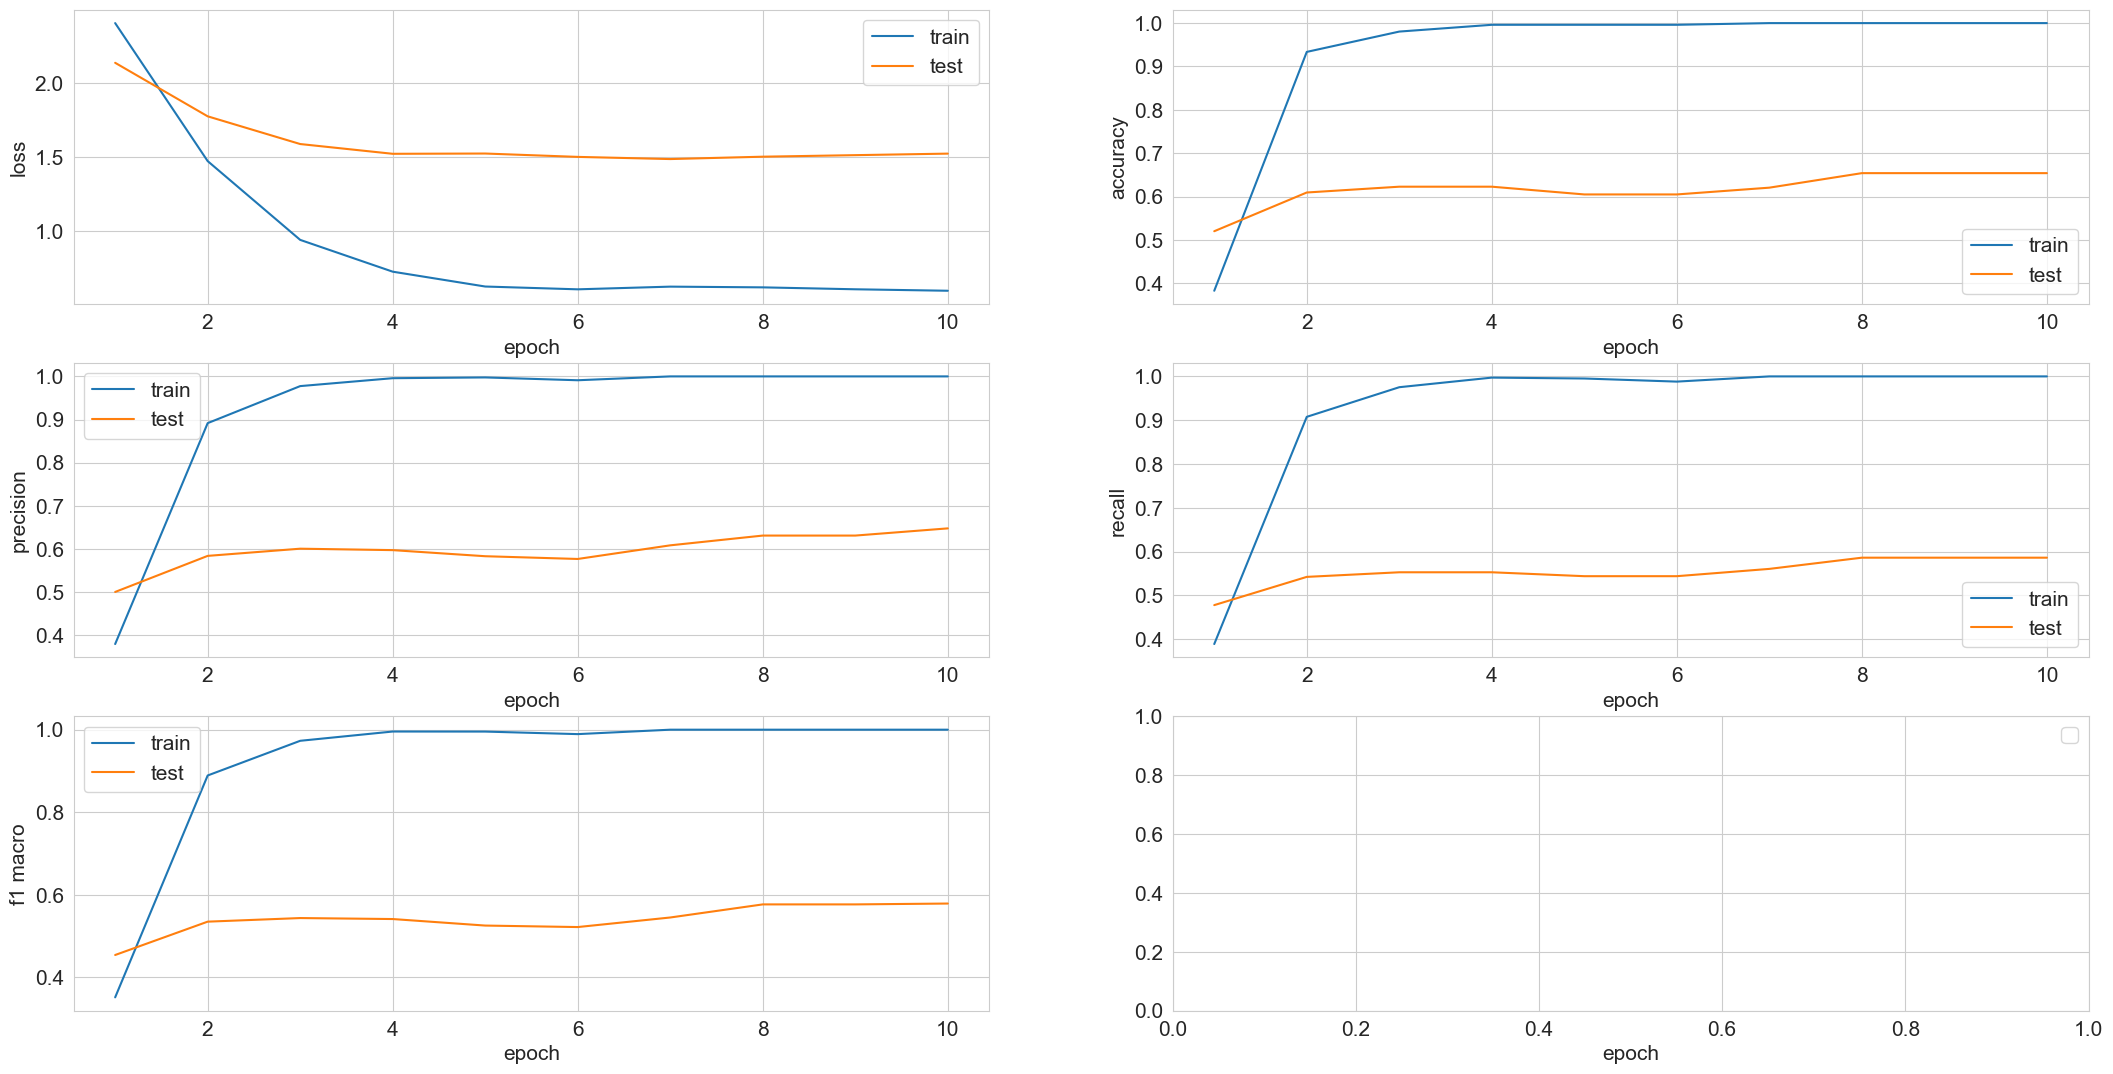

Epoch 10
val metrics
loss 1.5245697498321533
accuracy 0.6540178571428572
precision 0.6478571428571429
recall 0.5859126984126984
f1 macro 0.5788662131519275

train metrics
loss 0.5991353765130043
accuracy 1.0
precision 1.0
recall 1.0
f1 macro 1.0
--------------------------------------------------
0:01:56.751666


In [34]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, True, 
            saving_model=True, model_name=model_name, idx2target=idx2target)
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


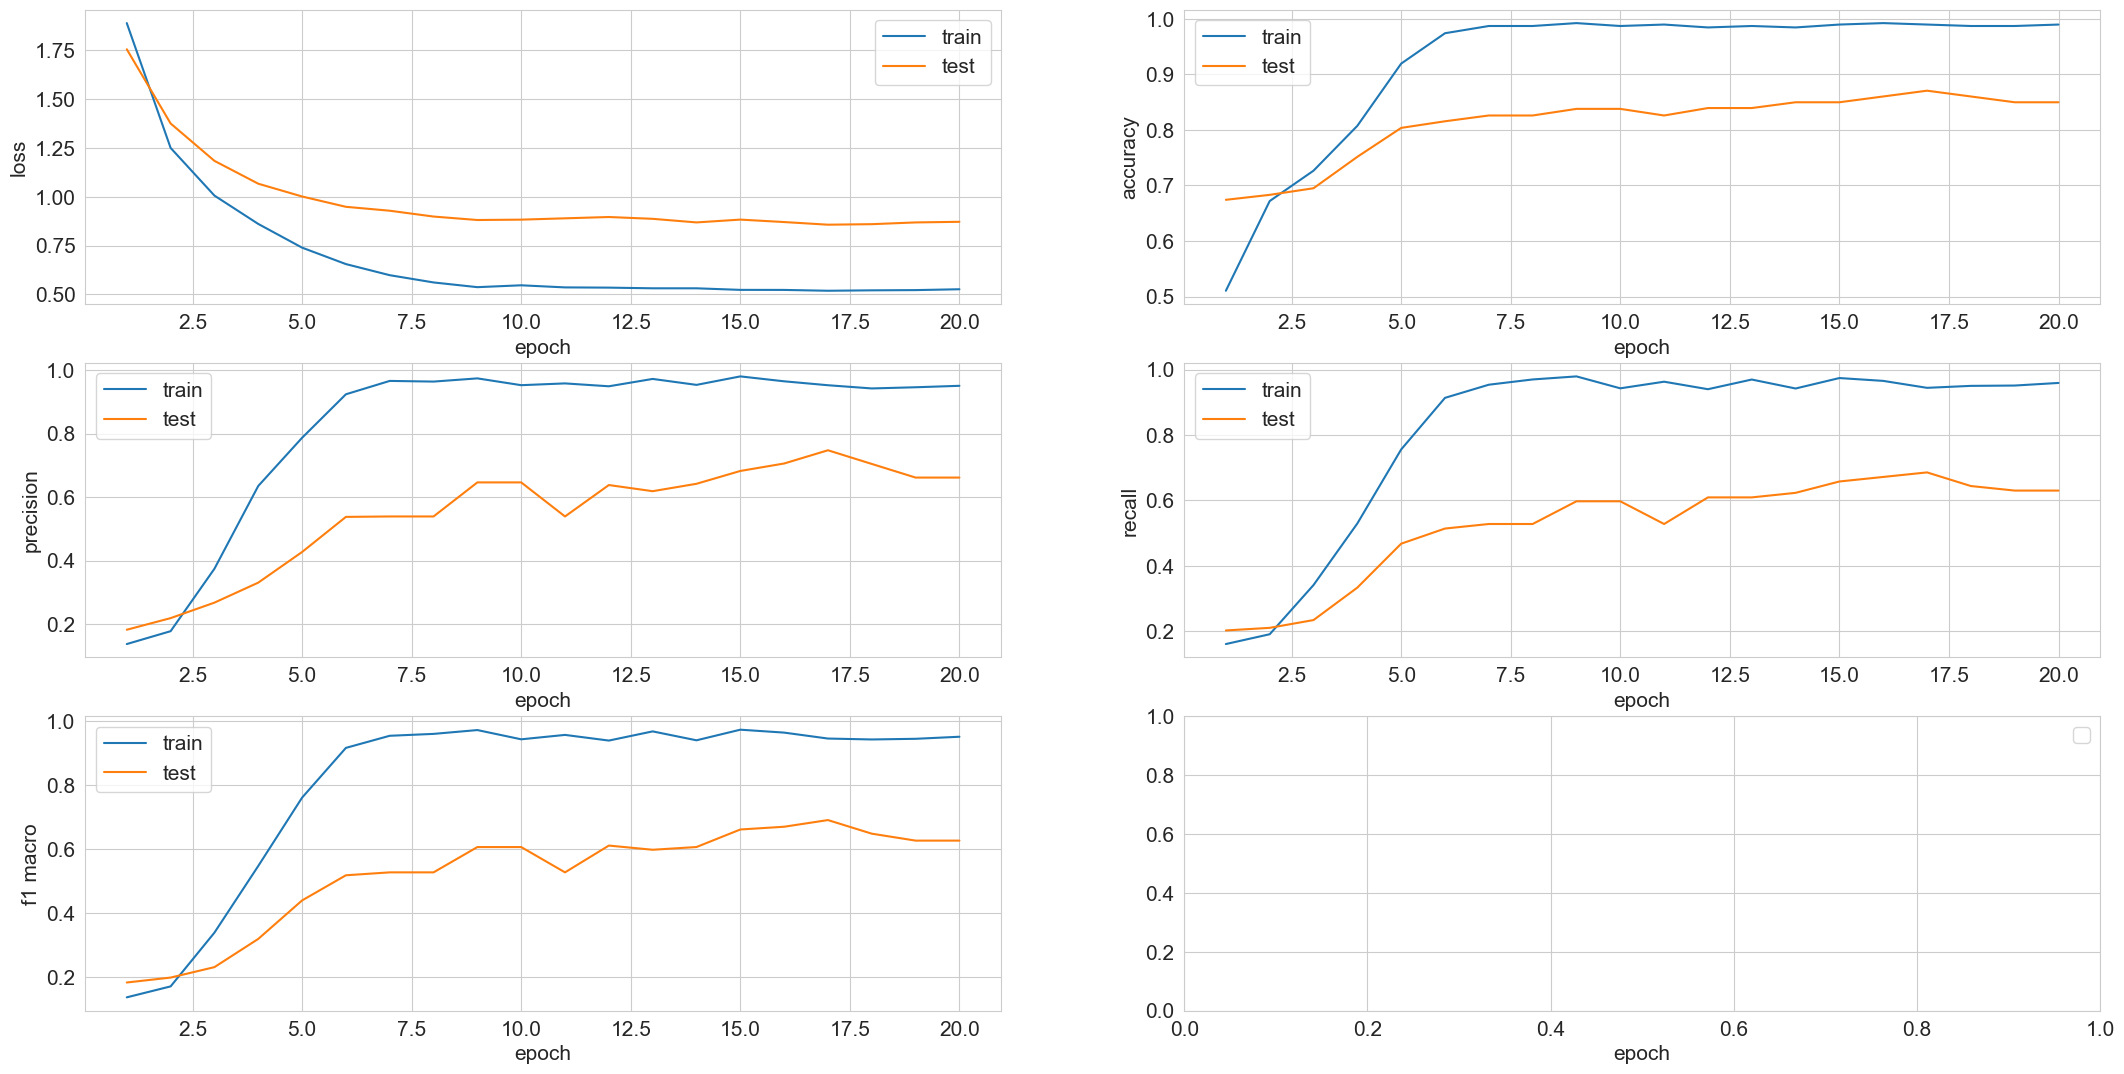

Epoch 20
val metrics
loss 0.871720532576243
accuracy 0.8497023809523809
precision 0.6614560439560438
recall 0.6299603174603173
f1 macro 0.6268649278160149

train metrics
loss 0.5260850290457407
accuracy 0.9895833333333334
precision 0.9503968253968255
recall 0.958994708994709
f1 macro 0.9511463844797179
--------------------------------------------------
0:05:47.117008


In [27]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, True, 
            saving_model=True, model_name=model_name, idx2target=idx2target)
b = datetime.now()
print(b - a)

# Prediction  

## Предсказание деревом  
работает по одной фотке за раз

In [21]:
@torch.no_grad()
def inference1(model, img, device):
    model.eval()
    img = img.to(device)
    logits = model(img)
    y_pred = np.argmax(logits.detach().cpu().numpy(), axis=-1)

    return y_pred


def prediction_tree(model_name, data, device):        
    with open(Path.cwd() / "models_tree" / model_name / 'idx2target.json') as fp:
        idx2target = json.load(fp, parse_int=True)
        idx2target = {int(k):v for k,v in idx2target.items()}
        
    NUM_CLASSES=len(idx2target)
    model = Model(
        module_features=pretrain_model.features,
        num_classes=NUM_CLASSES,
    )

    model.load_state_dict(torch.load(Path.cwd() / "models_tree" / model_name / "pytorch_model.bin"))
    y_pred = inference1(model.to(device), data, device)        
    model_name = idx2target[y_pred[0]]
    
    return model_name
    


def predictions(model_name, loader, device):
    y_preds = []
    
    for data in tqdm(loader):
        model_path = Path.cwd() / "models_tree" / model_name
        y_pred = prediction_tree(model_name, data, device)
#         print(y_pred)
        model_path = Path.cwd() / "models_tree" / y_pred

        while model_path.exists():
            y_pred = prediction_tree(y_pred, data, device)
#             print(y_pred)
            model_path = Path.cwd() / "models_tree" / y_pred
        
        y_preds.append(y_pred)
    
    return y_preds

In [25]:
#dataset_test = WbDataset(test_paths, None, processor)
#dataset_test = WbDataset(test_paths[:8], ytest, processor)
dataset_test = WbDataset(test_paths[:8], None, processor)


test_loader = accelerator.prepare_data_loader(DataLoader(dataset_test,
                                                         batch_size=1,
                                                         shuffle=False,
                                                         pin_memory=True,
                                                         generator=torch.Generator().manual_seed(SEED),
                                                         worker_init_fn=seed_worker)
                                             )

len(dataset_test)

8

In [26]:
y_preds = predictions(model_name, test_loader, device)
y_preds

  0%|          | 0/8 [00:00<?, ?it/s]

['Канцтовары_Бумажная&продукция_Наклейки',
 'Канцтовары_Бумажная&продукция_Книги&и&бланки&для&ведения&учета',
 'Канцтовары_Бумажная&продукция_Наклейки',
 'Канцтовары_Бумажная&продукция_Офисная&бумага',
 'Канцтовары_Бумажная&продукция_Бумага&для&заметок&и&стикеры',
 'Канцтовары_Письменные&принадлежности',
 'Канцтовары_Бумажная&продукция_Расписания&уроков',
 'Канцтовары_Бумажная&продукция_Бумага&для&заметок&и&стикеры']

In [23]:
test_paths[:8]

[WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Наклейки/card/18.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Книги&и&бланки&для&ведения&учета/card/12.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Наклейки/card/16.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Офисная&бумага/card/7.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Рисование&и&лепка/card/8.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Письменные&принадлежности/card/9.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Расписания&уроков/card/8.png'),
 WindowsPath('C:/temp/!hse-mlds-project-year2/data/data/Канцтовары_Бумажная&продукция_Бумага&для&заметок&и&стикеры/card/10.png')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


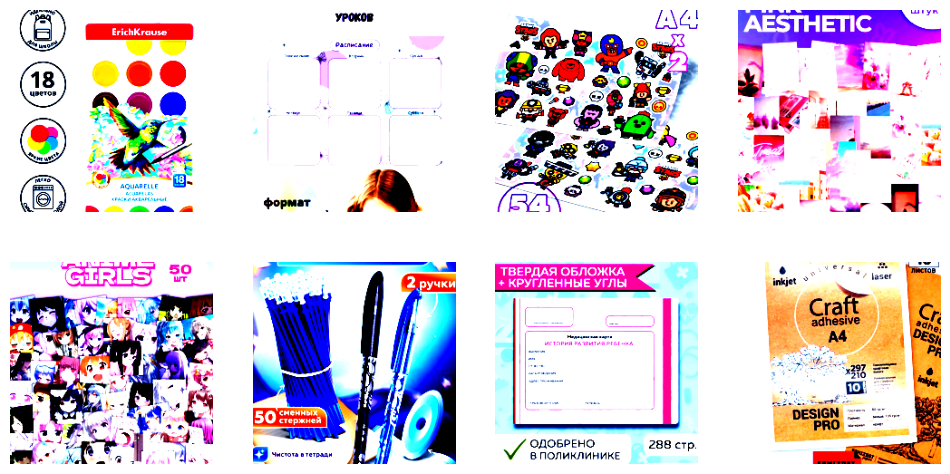

In [24]:
length = len(dataset_test)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise_pics(dataset_test, indexes)

## Предсказание по одной модели

In [35]:
@torch.no_grad()
def inference(model, loader, device):
    model.eval()
    y_preds = []
    for data in tqdm(loader):
        data = data.to(device)
        logits = model(data)
        y_pred = np.argmax(logits.detach().cpu().numpy(), axis=-1)

        y_preds.extend(y_pred)
    return y_preds

In [36]:
#dataset_test = WbDataset(test_paths, None, processor)
dataset_test = WbDataset(test_paths[:8], None, processor)

test_loader = accelerator.prepare_data_loader(DataLoader(dataset_test,
                                                         batch_size=1,
                                                         shuffle=False,
                                                         pin_memory=True,
                                                         generator=torch.Generator().manual_seed(SEED),
                                                         worker_init_fn=seed_worker)
                                             )

len(dataset_test)

8

In [39]:
#accelerator.load_state(Path.cwd() / "models_tree" / model_name)
model.load_state_dict(torch.load(Path.cwd() / "models_tree" / model_name / "pytorch_model.bin"))
model = model.to(device)

In [40]:
y_preds = inference(model, test_loader, device)
y_preds

  0%|          | 0/8 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 4, 1, 1]

In [22]:
for params in model.parameters():
    print(params)

Parameter containing:
tensor([[[[-6.3108e-02, -1.8766e-01, -1.5188e-01],
          [-4.9379e-01, -6.4248e-01, -5.8935e-01],
          [-6.8005e-01, -9.7448e-01, -7.6317e-01]],

         [[-1.6350e-02, -1.8482e-02,  6.2783e-02],
          [ 3.5436e-02,  5.8980e-02,  1.0693e-01],
          [ 1.6995e-01,  1.4699e-01,  1.8521e-01]],

         [[ 1.1395e-01,  1.6316e-01,  1.0483e-01],
          [ 4.0824e-01,  5.7489e-01,  4.7270e-01],
          [ 5.7547e-01,  7.1503e-01,  5.3702e-01]]],


        [[[ 2.9983e-03,  1.4297e-02,  5.9918e-02],
          [ 5.5779e-03,  3.0330e-02, -4.5050e-02],
          [ 1.2600e-01,  5.5075e-02, -9.2239e-01]],

         [[ 4.2316e-03, -6.6995e-02, -7.4151e-02],
          [ 1.4910e-02,  1.5604e-02, -6.8112e-02],
          [ 2.4632e-02, -4.4099e-02, -7.3383e-01]],

         [[-9.1925e-03, -3.3236e-02,  1.0019e-01],
          [ 3.9586e-03,  5.4139e-02,  1.0663e-01],
          [ 1.0968e-01,  3.5723e-02, -3.9510e-01]]],


        [[[ 1.2649e-01, -1.5025e-01,  2.4107

Parameter containing:
tensor([2.3564, 1.4216, 1.0730, 1.4022, 1.3710, 1.4293, 1.4185, 1.3027, 1.4130,
        1.3311, 1.3191, 1.4113, 1.2747, 1.0053, 1.4259, 1.2154, 1.1302, 1.2267,
        1.3232, 1.3284, 1.4337, 1.3051, 1.3990, 1.4093, 1.3401, 1.3844, 1.9727,
        1.3013, 1.3551, 1.1941, 1.5024, 0.5222, 1.2384, 1.4325, 1.2058, 1.4279,
        1.3983, 1.3026, 1.0540, 1.4732, 1.3778, 1.3901, 1.4568, 1.5218, 1.4718,
        1.0022, 1.3717, 1.3377, 1.3713, 1.4852, 1.4249, 1.3064, 1.5656, 1.1684,
        1.3656, 1.3477, 0.6932, 1.1874, 1.4241, 1.4892, 1.2960, 1.1630, 1.2862,
        1.5485, 1.1312, 1.4476, 1.3067, 1.2690, 1.3403, 1.2310, 1.1948, 1.2423,
        1.5635, 1.3756, 0.4785, 1.2122, 0.5295, 1.4623, 0.8721, 1.4561, 0.4390,
        1.2483, 1.4136, 1.1361, 1.3081, 1.1800, 1.2295, 1.2424, 1.3688, 1.4074,
        1.1948, 1.3129, 1.3603, 1.4925, 1.4193, 1.0988, 1.3899, 1.4507, 1.0844,
        1.2817, 1.4150, 1.1058, 1.4426, 1.4253, 1.4132, 1.4159, 1.6060, 1.3100,
        1.3476, 1.

In [69]:
#iterator = iter(test_loader)

# for i in range(8):
#     print(next(iterator)[0][0][0][0])

In [121]:
#iterator = iter(test_loader)

In [11]:
# сохранение
with open(Path.cwd() / "models_tree" / model_name / 'idx2target.json', 'w') as fp:
    idx2target_int = {int(k):v for k,v in idx2target.items()}
    json.dump(idx2target_int, fp)

In [108]:
# чтение
with open('data.json') as fp:
    data = json.load(fp, parse_int=True)
    idx2target_int = {int(k):v for k,v in data.items()}